In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=2)
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_20newsgroups
import seaborn as sns
import pandas as pd
from utilidades import *

# Evaluación de modelos y métricas de  rendimiento

El `accuracy` es la meidda de calidad por excelencia de un modelo. Sin embargo, no siempre es esa la mejor medida para decidir cuál es el mejor modelo posible.
Por defecto, en scikit-learn, se utiliza el ``accuracy`` para clasificación, que es el ratio de patrones correctamente clasificados y el $R^2$ para regresión, que es el coeficiente de determinación.
Estas medidas son razonables para muchos escenarios. Sin embargo, dependiendo de la tarea que estemos tratando, estas no tienen porque ser las mejores opciones (y a veces pueden ser opciones muy poco recomendables).
Vamos a centrarnos en la tarea de clasificación, utilizaremos el problema de dígitos manuscritos. Scikit-learn tiene muchas medidas de calidad como parte del modilo ``sklearn.metrics`` para ayudarnos a entrenar un clasificador y luego evaluarlo de distintas formas:

In [93]:
digits = load_digits()
X, y = digits.data, digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=1,
                                                    stratify=y,
                                                    test_size=0.25)

classifier = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
y_test_pred = classifier.predict(X_test)

print("ACCURACY: %f"%(classifier.score(X_test, y_test)))

ACCURACY: 0.982222


Vemos que un 98% de patrones se predijo de forma correcta. Para problemas multi-clase, a veces es muy útil saber qué clases son más difíciles de predecir y cuáles más fáciles o incluso qué tipo de errores son los más comunes. Una forma de tener más información en este sentido es la **matriz de confusión**, que muestra para cada clase (filas) cuántas veces se predicen qué clases (columnas).

In [94]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_test_pred) 
# Cada columna indica cuantos elementos se predijeron 
#y como de que clase

array([[45,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 46,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 44,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 45,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0, 45,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 44,  1,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0, 45,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 45,  0,  0],
       [ 0,  3,  0,  0,  0,  0,  0,  0, 39,  1],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0, 44]])

A veces un gráfico es más fácil de leer:

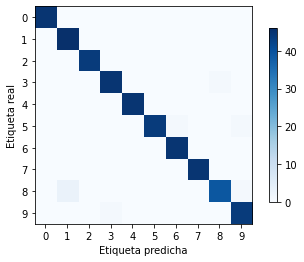

In [95]:
plt.imshow(confusion_matrix(y_test, y_test_pred), cmap="Blues")
plt.colorbar(shrink=0.8)
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta real");

Podemos ver que la mayoría de valores están en la diagonal principal, lo que significa que predecimos casi todos los ejemplos correctamente. Las entradas que no están en la diagonal principal nos muestran que hay algunos ochos clasificados como unos.

Otra función muy útil es ``classification_report`` que nos proporciona los valores de precisión, recall, medida $f$ y el soporte para todas las clases. La precisión nos dice cuantas de las predicciones de una clase, son realmente de esa clase. Sea TP, FP, TN, FN "true positive" (verdaderos positivos), "false positive", (falsos positivos),"true negative" (verdaderos negativos) y "false negative" (falsos negativos), respectivamente:

Precision = TP / (TP + FP)

El recall representa cuantos ejemplos de la clase fueron clasificados correctamente (accuracy considerando solo esa clase):

Recall = TP / (TP + FN)

El valor F1 es la media geométrica de la precisión y el recall:

F1 = 2 x (precision x recall) / (precision + recall)

Todas estas métricas están en el intervalo $[0,1]$, donde un 1 es una puntuación perfecta.

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.94      1.00      0.97        46
           2       1.00      1.00      1.00        44
           3       0.98      0.98      0.98        46
           4       1.00      1.00      1.00        45
           5       1.00      0.96      0.98        46
           6       0.98      1.00      0.99        45
           7       1.00      1.00      1.00        45
           8       0.97      0.91      0.94        43
           9       0.96      0.98      0.97        45

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



Estas métricas son especialmente útiles en dos casos particulares:
1. Clasificación no balanceada, es decir, una o varias clases son mucho menos frecuentes (hay menos casos en el conjunto de entrenamiento) que el resto de clases.
2. Costes asimétricos, esto es, algunos tipos de errores son más "costosos" que el resto.

Vamos a ver el primer caso. Imagina que tenemos una razón de 1:9 para un problema de clasificación (lo cuál no es muy exagerado, piensa por ejemplo en la predicción de clicks sobre banners de publicidad, donde a lo mejor solo un 0.001% de los anunciados son visitados):

In [23]:
np.bincount(y) / y.shape[0]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

Para probar este escenario, vamos a clasificar el dígito 3 contra el resto (el problema de clasificación es un problema binario, ¿es este dígito un 3?):

In [24]:
X, yb = digits.data, digits.target == 3

Ahora vamos a aplicar validación cruzada con un clasificador para ver que tal funciona:

In [25]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.svm import SVC

cross_val_score(SVC(), X, yb)

array([1.  , 0.96, 1.  , 1.  , 0.96])

Nuestro clasificador tienen un 90% de acierto siempre. ¿Es bueno o malo? Ten en cuenta que el 90% de los dígitos no son un 3. Vamos a ver que tal funciona un clasificador simple, que siempre predice la clase más frecuenta (ZeroR):

In [96]:
from sklearn.dummy import DummyClassifier
cross_val_score(DummyClassifier("most_frequent"), X, y)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass strategy=most_frequent as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([0.1, 0.1, 0.1, 0.1, 0.1])

También un 90%, como esperábamos. Por tanto, podemos pensar que el clasificador SVC no es demasiado bueno, ya que funciona igual que una estrategia que ni si quiera utiliza los datos de entrada. De todas formas, esto sería sacar conclusiones muy rápido ya que, en general, el accuracy no es una buena medida de rendimiento para bases de datos no balanceadas.

In [9]:
np.bincount(yb) / yb.shape[0]

array([0.9, 0.1])

## Curvas ROC

Una medida mucho mejor se puede obtener utilizando las llamadas curvas de operación características (ROC, *Receiver operating characteristics*). Una curva ROC trabaja con las medidas de incertidumbre de un clasificador, por ejemplo la función de decisión de un ``SVC``. En lugar de utilizar el cero como umbral para distinguir ejemplos negativos de ejemplos positivos, la curva ROC considera todos los posibles umbrales y almacena el ratio de ejemplos de la clase positiva que se predicen correctamente (TPR) y el ratio de fallos para la clase negativa (FPR).

El siguiente gráfico compara la curva ROC de tres configuraciones distintas de nuestro clasificador para la tarea "tres vs el resto".

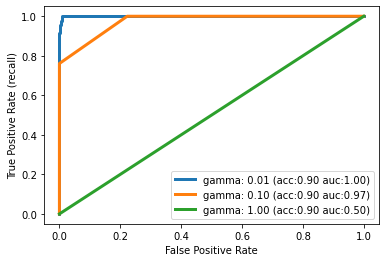

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, yb, random_state=42)

for gamma in [.01, .095, 1]:
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (recall)")
    svm = SVC(gamma=gamma).fit(X_train, y_train)
    decision_function = svm.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, decision_function)
    acc = svm.score(X_test, y_test)
    auc = roc_auc_score(y_test, svm.decision_function(X_test))
    plt.plot(fpr, tpr, label="gamma: %.2f (acc:%.2f auc:%.2f)" % (gamma, acc, auc), linewidth=3)
plt.legend(loc="best");

Si el valor de umbral es muy bajo, tendremos muchos falsos positivos y por tanto un TPR muy alto y un FPR muy alto (porque casi todo lo clasificamos como positivo). Si usamos un umbral muy alto, habrá muy pocos falsos positivos (casi todo se predice como negativo), y por tanto el TPR será bajo y el FPR también. Por lo que, en general, la curva va desde arriba a la derecha hasta abajo a la izquierda. Una línea diagonal indica que el rendimiento es aleatorio, mientras que el objetivo ideal sería que la curva se desplace arriba a la izquierda. Esto significa que el clasificador daría siempre valores más altos de la función de decisión a los ejemplos positivos que a los ejemplos negativos.

En este sentido, esta curva solo considera el orden asignado a los ejemplos positivos y negativos según la función de decisión, pero no el valor asignado. Como puedes ver a partir de las curvas y de los valores de accuracy, aunque todos los clasificadores tengan el mismo accuracy, uno de ellos tiene una curva ROC perfecta, mientras que otro se comporta igual que un clasificador aleatorio.

Para realizar búsqueda en rejilla y validación cruzada, nos gustaría que la evaluación se guiase por un único valor numérico. Una buena forma de hacer esto es considera el área bajo la curva ROC (*area under the curve*, AUC). Podemos usar esto en ``cross_val_score`` especificando ``scoring="roc_auc"``:

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(SVC(), X, yb, scoring="roc_auc")

array([1.  , 1.  , 1.  , 1.  , 0.97])

Compara el rendimiento con el DummyClassifier:

In [12]:
from sklearn.linear_model import LogisticRegression
cross_val_score(DummyClassifier("most_frequent"), X, yb, scoring="roc_auc")

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass strategy=most_frequent as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([0.5, 0.5, 0.5, 0.5, 0.5])

## Funciones de rendimiento por defecto y personalizadas

Hay muchas medidas de rendimiento, que son útiles para problemas muy distintos. Puedes encontrarlas en el diccionario "SCORERS". La documentación explica todas ellas.

In [13]:
from sklearn.metrics.scorer import SCORERS
print(SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


También es posible escribir tu propia medida de rendimiento. En lugar de una cadena, puedes pasar un nombre de función como argumento ``scoring``, esto es, un objeto con un método ``__call__`` (o lo que es lo mismo, una función). Esa función debe recibir un modelo, un conjunto de características ``X_test`` y un conjutno de etiquetas ``y_test``, y devolver un valor real. Los valores más altos deberían indicar que el modelo es mejor.

Para probarlo, vamos a reimplementar la medida estándar de accuracy:

In [14]:
def my_accuracy_scoring(clf, X, y):
    return np.mean(clf.predict(X) == y)

cross_val_score(SVC(), X, y, scoring=my_accuracy_scoring)

array([0.96, 0.94, 0.98, 0.99, 0.94])

<div class="alert alert-success">
    <b>EJERCICIO</b>:
     <ul>
      <li>
      En las secciones anteriores, normalmente usábamos el accuracy para evaluar el rendimiento de nuestros clasificadores. Una medida relacionada de la cuál no hemos hablado aún es el accuracy medio por clase (average-per-class accuracy, APCA). Como recordarás, el accuracy se puede definir como:

$$ACC = \frac{TP+TN}{n},$$

donde *n* es el número total de ejemplos. Esto puede generalizarse para multiclase como:

$$ACC =  \frac{T}{n},$$

donde *T* es el número total de predicciones correctas (diagonal principal).
      </li>
    </ul>
    ![](figures/average-per-class.png)
    <li>
    Dados los siguientes arrays de etiquetas verdaderas y de etiquetas predichas, ¿puedes implementar una función que utilice la métrica accuracy para conseguir el APCA?
    </li>
</div>

In [28]:
y_true = np.array([0, 0, 0, 1, 1, 1, 1, 1, 2, 2])
y_pred = np.array([0, 1, 1, 0, 1, 1, 2, 2, 2, 2])

confusion_matrix(y_true, y_pred)

array([[1, 2, 0],
       [1, 2, 2],
       [0, 0, 2]])

## Comparación de modelos

Podemos comparar los diferentes modelos para determinar cual de estos es el que mejor funciona. Para ello tendermos que definir un esquema de validación. Por ejemplo para el problema de los digitos evaluaremos los algoritmos de $k$NN, SVM con kernel gaussiano, svm lineal, el clasificador Ridge y una Perceptrón multicapa. Como usalmente para los datos de prueba no se cuenta con las etiquetas, se realiza el ajuste del modelo utilizando solamente los datos de entremamiento. 

El esquema que realizaremos será realizar un porceso de validación cruzada utilizando con 5 folds y utilizando como medidas de calidad $f_1$ y recall.

Utilizaremos el conjunto de datos `20news_groups`. El conjunto se compone de 18000 publicaciones clasificadas en 20 clases. Los datos están divididos en conjuntos de entraimiento y de prueba.

In [29]:
#Cargamos los dos conjuntos
ng_train = fetch_20newsgroups(subset='train')
ng_test = fetch_20newsgroups(subset='test')

In [30]:
print(ng_train.data[:1]) #las primera 2 noticias

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"]


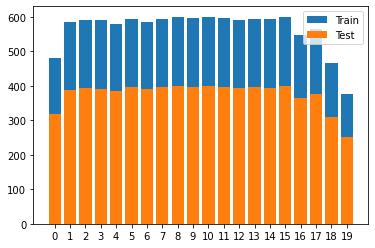

In [31]:
dc_train=np.bincount(ng_train.target); # la distribución de las 20 clases
dc_test=np.bincount(ng_test.target);
plt.bar(range(len(dc_train)), dc_train, label="Train")
plt.bar(range(len(dc_test)), dc_test, label="Test")
plt.xticks([i for i in range(20)]);
plt.legend()

In [155]:
train_texts=tokenize_sentences(ng_train.data)
yT= ng_train.target # eqiquetas conjunto de entrenamiento
test_texts=tokenize_sentences(ng_test.data)
yt= ng_test.target # eqiquetas conjunto de prueba

primero vamos a transformar el texto 

In [125]:
#Entrenamos el modelo
from gensim.models import Word2Vec
total=np.concatenate((train_texts,test_texts))
model = Word2Vec(size=300)
model.build_vocab(sentences=total)

In [119]:
#Entrenamos el modelo
model.train(sentences=total,total_examples=len(total), epochs=5)

(19267602, 24996745)

In [127]:
def emmbed_sentences(sentences,model):
    embeddings=np.array([np.mean([model.wv[token] for token in sentence if token in model.wv.vocab],axis=0) 
                   for sentence in sentences])
    return embeddings

In [128]:
#transformamos el conjunto de entrenamiento
trainv=emmbed_sentences(train_texts,model)
testv=emmbed_sentences(test_texts,model)

In [146]:
print(trainv.shape, testv.shape)

(11314, 300) (7532, 300)


Para cada clasificador vamos ejecutar 5 folds y resgitramos las medidas de f1 y recall. Con la información construiremos un `dataframe`.

In [130]:
# Cross_validate regresa un diccionario
cross_validate(GaussianNB(),trainv,yT, scoring=['f1_weighted', 'recall_macro'])

{'fit_time': array([0.03, 0.02, 0.02, 0.02, 0.02]),
 'score_time': array([0.1 , 0.07, 0.07, 0.07, 0.07]),
 'test_f1_weighted': array([0.24, 0.24, 0.24, 0.24, 0.22]),
 'test_recall_macro': array([0.25, 0.25, 0.24, 0.25, 0.24])}

In [140]:
res=[]
# La lista de modelos
lista_clasificadores={"kNN":KNeighborsClassifier(), "SVM RBF":SVC(), 
               "Naive Bayes":GaussianNB(), "Ridge":RidgeClassifier(), 
               "Linear SVM":LinearSVC(), "Perceptron ML": MLPClassifier()}
for nombre,clf in lista_clasificadores.items():
    print(f"training: {nombre}")
    r=cross_validate(clf,trainv,yT, scoring=['f1_weighted', 'recall_macro'])
    for f1score, recallscore in zip(r['test_f1_weighted'],r['test_recall_macro']):
        res.append({'Classifier':nombre, 'Measurement':'f1','Value':f1score})
        res.append({'Classifier':nombre, 'Measurement':'recall','Value':recallscore})

training: kNN
training: SVM RBF
training: Naive Bayes
training: Ridge
training: Linear SVM
training: Perceptron ML


/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multi

In [147]:
df=pd.DataFrame(res)
df.head()

,Classifier,Measurement,Value
0,kNN,f1,0.416903
1,kNN,recall,0.411081
2,kNN,f1,0.432611
3,kNN,recall,0.429328
4,kNN,f1,0.399780


<AxesSubplot:xlabel='Value', ylabel='Classifier'>

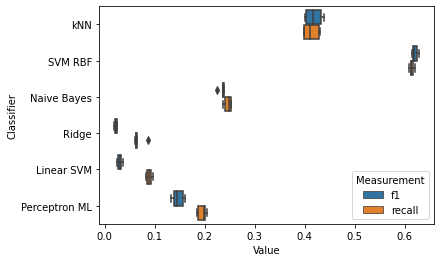

In [148]:

sns.boxplot(data=df, y='Classifier', x='Value', orient='h',
            hue='Measurement')

De la grafica podemos ver que el mejor clasificador para el este problema con la representación `word2vec` utilizada es el clasificador SVM RBF. Como en este caso tenemos la etiquetas del conjunto de entrenamento podemos ver que tan bien generaliza el modelo SVM RBF. 

In [158]:
from sklearn.metrics import f1_score, recall_score
clf=SVC()
clf.fit(trainv,yT)
yp=clf.predict(testv)
f1=f1_score(yt,yp, average='weighted')
recall=f1_score(yt,yp,average='macro')
print(f"Classifier: SVM RBF, f1 weighted: {f1}, macro recall: {recall}")

Classifier: SVM RBF, f1 weighted: 0.512284496631075, macro recall: 0.5060869341642993


In [ ]:
clf=KNN
clf.fit(trainv,yT)
yp=clf.predict(testv)
f1=f1_score(yt,yp, average='weighted')
recall=f1_score(yt,yp,average='macro')
print(f"Classifier: SVM RBF, f1 weighted: {f1}, macro recall: {recall}")

### Incorporación de conocimiento

Derivado de que contamos con multiples representaciónes podemos combinarlas para tratar de mejorar el rendimiento de nuestro clasificador. Probemos unir la representación obtenida mediante `Word2Vec` con un modelo pre-entrenado, por ejemplo de  FastText `fasttext-wiki-news-subwords-300`. La forma más directa es simplemente concatenando las características obtenidas por cada modelo. Formalmente, si $X_{\mathit{w2v}}$ es la repreentación obtenida por `Word2Vec` y $X_{\mathit{ft}}$ por el modelo pre-entrenamo de `FastText` podemos obtener una nueva representación $X_N=X_{\mathit{w2v}} \cup X_{\mathit{ft}}$ y utilizar la nueva representación para entrenar un clasificador. Por ejemplo entrenemos un clasificador SVM con ls nueva representación

In [160]:
#Cargamos el modelo pre-entreando obtenemo 
import gensim.downloader as api
model_pretrain= api.load('fasttext-wiki-news-subwords-300') 
trainv2=emmbed_sentences(train_texts,model_pretrain)
testv2=emmbed_sentences(test_texts,model_pretrain)

<ipython-input-127-922a6504b87f>:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  embeddings=np.array([np.mean([model.wv[token] for token in sentence if token in model.wv.vocab],axis=0)


In [165]:
# Obtenemos una representación de 600 caracteristicas
trainn=np.concatenate((trainv,trainv2), axis=1) 
testn=np.concatenate((testv,testv2), axis=1) 
trainn.shape

(11314, 600)

In [166]:
# Probamos SVM RBF con la nueva respresentación 
clf=SVC()
clf.fit(trainn,yT)
yp=clf.predict(testn)
f1=f1_score(yt,yp, average='weighted')
recall=f1_score(yt,yp,average='macro')
print(f"Classifier: SVM RBF, f1 weighted: {f1}, macro recall: {recall}")

Classifier: SVM RBF, f1 weighted: 0.6251495974058465, macro recall: 0.6101864728352294


Para este caso obtuvimos un incremento del 10%, aunque habría pirmero que determinar cual es el perfomance de solo útilizar el modelo pre-entrenado.

In [167]:
clf=SVC()
clf.fit(trainv2,yT)
yp=clf.predict(testv2)
f1=f1_score(yt,yp, average='weighted')
recall=f1_score(yt,yp,average='macro')
print(f"Classifier: SVM RBF, f1 weighted: {f1}, macro recall: {recall}")

Classifier: SVM RBF, f1 weighted: 0.6250578000585268, macro recall: 0.6100899148366165


Podemos ver que el mejora e marginal, de solo un 0.01% mayor cuando solo se usa el modelo pre-entrenado. Está forma de incorporación de conocimiento es muy simple, ya que lo único que se hace es aumentar características sin considerar que tan importantes pueden ser la respresentaciones.

<div class="alert alert-success">
    <b>Tarea</b>:
     <ul>
      <li>
      Realice un análisis similar para los textos de los tweest de humor
      </li>
    <li>Incluya a la comparativa los siguientes modelos de texto:        
    </li>
        <ol>
        <li>sklearn.feature_extraction.text.CountVectorize</li>
        <li>sklearn.feature_extraction.text.TfidfVectorizer</li>
        <li>gensim.models.FastText</li>
        <li>gensim.models.Word2Vec</li>
         <li>Un modelo pre-entrenado de los disponibles en gensim.downloader.api</li>
        </ol>

  </ul>